In [1]:
import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal
import os
tavily = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

In [2]:

RESEARCHER_INSTRUCTIONS = """You are a research assistant conducting research on the user's input topic. For context, today's date is {date}.

<Task>
Your job is to use tools to gather information about the user's input topic.
You can use any of the tools provided to you to find resources that can help answer the research question. You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.
</Task>

<Available Tools>
You have access to 1 main tool:
1. **tavily_search**: For conducting web searches to gather information

**CRITICAL: after each search reflect on results and plan next steps**
</Available Tools>

<Instructions>
Think like a human researcher with limited time. Follow these steps:

1. **Read the question carefully** - What specific information does the user need?
2. **Start with broader searches** - Use broad, comprehensive queries first
3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?
4. **Execute narrower searches as you gather information** - Fill in the gaps
5. **Stop when you can answer confidently** - Don't keep searching for perfection
</Instructions>

<Hard Limits>
**Tool Call Budgets** (Prevent excessive searching):
- **Simple queries**: Use 1-2 search tool calls maximum
- **Normal queries**: Use 2-3 search tool calls maximum
- **Very Complex queries**: Use up to 5 search tool calls maximum
- **Always stop**: After 5 search tool calls if you cannot find the right sources

**Stop Immediately When**:
- You can answer the user's question comprehensively
- You have 3+ relevant examples/sources for the question
- Your last 2 searches returned similar information
</Hard Limits>

<Show Your Thinking>
After each search tool analyze the results:
- What key information did I find?
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?
</Show Your Thinking>
"""


In [3]:
@tool
def tavily_search(query: str) -> str:
    """
    Search the web for real-time information using Tavily API.
 
    Input:
        query (str): A search query string describing the information you want.
                     Example: "latest AI news in 2025"
 
    Output:
        str: A formatted string containing up to 3 search results with titles and URLs.
             Example:
                 - OpenAI releases GPT-5: https://example.com/openai-news
                 - Advances in AI Agents: https://example.com/ai-agents
                 - Future of Generative AI: https://example.com/genai-future
    """
    try:
        results = tavily.search(query, max_results=3)  # returns dict with 'results'
        contents = [r.get("content", "").strip() for r in results.get("results", []) if r.get("content")]
        
        if not contents:
            return "No relevant content found."
        
        # Join all content into one paragraph
        paragraph = " ".join(contents)
        
        # Optional: shorten to first 400 characters for brevity
        if len(paragraph) > 400:
            paragraph = paragraph[:400].rsplit('.', 1)[0] + '.'
        
        return paragraph

    except Exception as e:
        return f"Error during Tavily search: {e}"


In [4]:


from langchain_core.tools import Tool


tools = [
    Tool(
        name="tavily_search", 
        func=tavily_search, 
        description="Perform web searches to gather research information."
    )
]


In [ ]:

from langchain_core.tools import tool

from langchain import hub
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(model = 'gpt-4o-mini',temperature=0.7,api_key=os.getenv('open_ai'))


In [6]:
llm_with_tools = llm.bind_tools(tools)
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System
# Node
def assistant(state: MessagesState):
   # print('entire chat')
   # for m in state['messages']:
   #    m.pretty_print()
   return {"messages": [llm_with_tools.invoke([RESEARCHER_INSTRUCTIONS] + state["messages"])]}

C:\Users\ACER\AppData\Local\Temp\ipykernel_11660\742060716.py:10: LangGraphDeprecatedSinceV10: ToolNode has been moved to langchain.agents.tool_node. Please update your import to 'from langchain.agents.tool_node import ToolNode'. Deprecated in LangGraph V1.0 to be removed in V2.0.
  builder.add_node("tools", ToolNode(tools))


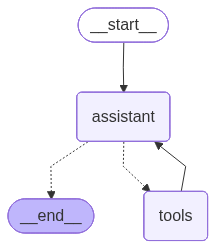

In [7]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="what is artificial intelligence")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is artificial intelligence
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_MVROmXIta9rdnw97Fva43GuI)
 Call ID: call_MVROmXIta9rdnw97Fva43GuI
  Args:
    __arg1: What is artificial intelligence?
================================= Tool Message =================================
Name: tavily_search

Artificial intelligence (AI) is technology that enables machines to demonstrate human-like reasoning and capabilities such as autonomous decision making.
================================== Ai Message ==================================

The search returned a foundational definition of artificial intelligence (AI) as technology that allows machines to exhibit human-like reasoning and capabilities, including autonomous decision-making. 

### Key Information Found:
- AI enables machines to perform tasks that typically require human intelligence.
- 